In [1]:
from keras.models import load_model

C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import os
from random import randint
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from tensorflow.keras.preprocessing.image import load_img
# from keras import Model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.models import load_model
# from keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

In [3]:
import tensorflow as tf

In [5]:
from metrics import my_iou_metric

In [9]:
dependencies = {
    'my_iou_metric': my_iou_metric
}

model = tf.keras.models.load_model('models/keras (3).model', custom_objects=dependencies)

W0819 16:34:32.783292 21040 deprecation.py:506] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 16:34:32.785293 21040 deprecation.py:506] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 16:34:32.787292 21040 deprecation.py:506] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\

In [8]:
model = tf.keras.models.load_model('model_with_flip.model')

OSError: Unable to open file (unable to open file: name = 'model_with_flip.model', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [13]:
train_df = pd.read_csv("tgs/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("tgs/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [15]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs
x_test = np.array([(np.array(load_img("tgs/test/images/{}.png".format(idx), color_mode="grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, 101, 101, 1)
preds_test = model.predict(x_test)
pred_dict = {idx: RLenc(np.round(preds_test[i] > 0.7551020408163265)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

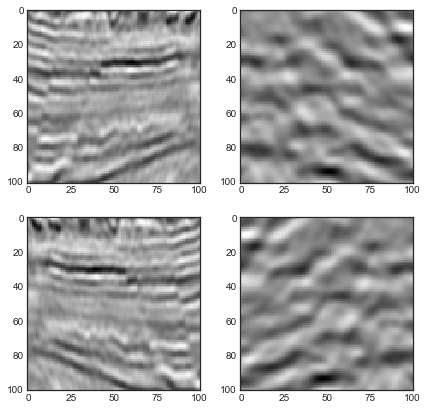

In [41]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2

img = cv2.imread('train/images/00cda0328c.png') /255
img2 = cv2.imread('train/images/000e218f21.png') /255
aug = iaa.Fliplr(1)
imga, imga2 = aug.augment_images([img, img2])
f, ax = plt.subplots(2,2, figsize=(7,7))
ax[0][0].imshow(img)
ax[0][1].imshow(img2)
ax[1][0].imshow(imga)
ax[1][1].imshow(imga2)

In [63]:
def scale(image_set, mask_set):
    aug = iaa.Affine(scale=1.2674)

    imgs = aug.augment_images(image_set)
    masks = aug.augment_images(mask_set)
    return imgs, masks

(101, 101)

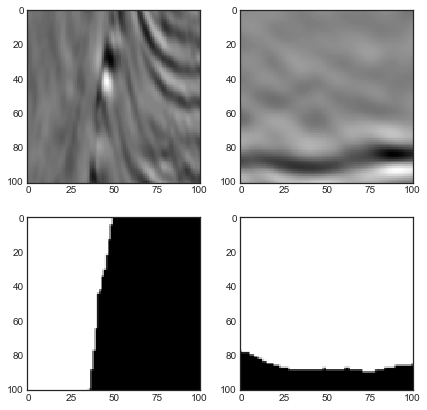

In [66]:
img = cv2.imread('train/images/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('train/images/0bca43f7ff.png', cv2.IMREAD_GRAYSCALE) 
mask1 = cv2.imread('train/masks/0ba541766e.png', cv2.IMREAD_GRAYSCALE) 
mask2 = cv2.imread('train/masks/0bca43f7ff.png', cv2.IMREAD_GRAYSCALE) 
imgs, masks = scale([img, img2], [mask1, mask2])
f, ax = plt.subplots(2,2, figsize=(7,7))
ax[0][0].imshow(imgs[0], cmap='gray')
ax[0][1].imshow(imgs[1], cmap='gray')
ax[1][0].imshow(masks[0], cmap='gray')
ax[1][1].imshow(masks[1], cmap='gray')

In [67]:
def get_resize(width=128, height=128):

    def resize(image_set, mask_set):
        aug = iaa.Resize({"height": height, "width": width})
        imgs = aug.augment_images(image_set)
        masks = aug.augment_images(mask_set)
        return imgs, masks

    return resize

True

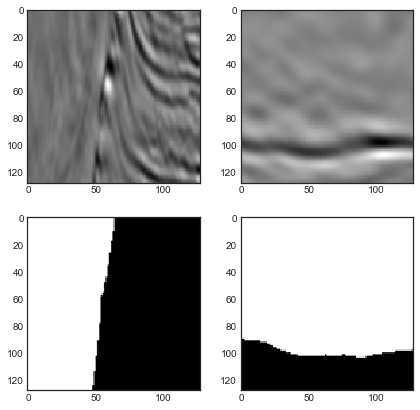

In [73]:
img = cv2.imread('train/images/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('train/images/0bca43f7ff.png', cv2.IMREAD_GRAYSCALE) 
mask1 = cv2.imread('train/masks/0ba541766e.png', cv2.IMREAD_GRAYSCALE) 
mask2 = cv2.imread('train/masks/0bca43f7ff.png', cv2.IMREAD_GRAYSCALE) 
imgs, masks = get_resize()([img, img2], [mask1, mask2])
f, ax = plt.subplots(2,2, figsize=(7,7))
ax[0][0].imshow(imgs[0], cmap='gray')
ax[0][1].imshow(imgs[1], cmap='gray')
ax[1][0].imshow(masks[0], cmap='gray')
ax[1][1].imshow(masks[1], cmap='gray')
cv2.imwrite('img.png', masks[0])

In [103]:
def arith_or(array1, array2):
    res = []
    for a, b in zip(array1, array2):
        if (a==1.0 or b == 1.0):
            res.append(1.0)
        else:
            res.append(0.0)
            
    return res

In [112]:
def arith_and(array1, array2):
    res = []
    for a, b in zip(array1, array2):
        if (a==1.0 and b == 1.0):
            res.append(1.0)
        else:
            res.append(0.0)
            
    return res

In [116]:
def dice_loss(y_true, y_pred):
    y_true_f = np.ravel(y_true)
    y_pred_f = np.ravel(y_pred)
    intersection = arith_and(y_true_f, y_pred_f)
    union = arith_or(y_true_f, y_pred_f)
    score = sum(union) / (2 * sum(intersection))
    return 1 - score

In [117]:
dice_loss([1,1,0,1], [1,1,0,0])

0.25

In [19]:
def flip(img, mask, prob):
    aug = iaa.Fliplr(prob)
    res = np.concatenate([img, mask], axis=2)
    res = aug.augment_image(res)
    return res[:,:,0], res[:,:,1]

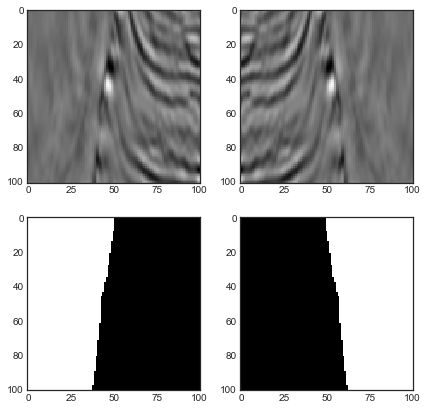

In [29]:
import cv2
import imgaug.augmenters as iaa
img = cv2.imread('train/images/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
mask1 = cv2.imread('train/masks/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
img = img.reshape([101, 101, 1])
mask1 = mask1.reshape([101, 101, 1])
img2, mask2 = flip(img, mask1, 0.5)


f, ax = plt.subplots(2,2, figsize=(7,7))
ax[0][0].imshow(img.squeeze(), cmap='gray')
ax[0][1].imshow(img2.squeeze(), cmap='gray')
ax[1][0].imshow(mask1.squeeze(), cmap='gray')
ax[1][1].imshow(mask2.squeeze(), cmap='gray')

In [23]:
from albumentations import (RandomContrast, RandomBrightness, ShiftScaleRotate, HorizontalFlip, Compose
)

In [24]:
def strong_aug(p=1):
  return Compose([
        RandomBrightness(p=0.2, limit=0.2),
        RandomContrast(p=0.1, limit=0.2),
        ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.6, rotate_limit=0, p=0.7),
        HorizontalFlip(p=0.5)
    ], p=p)

In [37]:
import cv2
augment = strong_aug()
img = cv2.imread('train/images/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
mask1 = cv2.imread('train/masks/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
data = {"image": img, "mask": mask1}
augmented = augment(**data)
img.shape

(101, 101)

In [80]:
import random
random.random()

0.8510974024388122

In [17]:
import tensorflow as tf

(101, 101)
(101, 101)


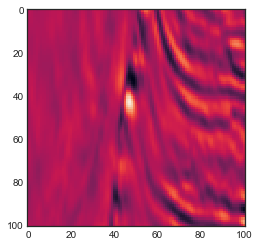

In [37]:
import cv2
img = cv2.imread('tgs/train/images/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
mask1 = cv2.imread('tgs/train/masks/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)
img2 = cv2.resize(img, (202, 202), interpolation=cv2.INTER_AREA)
print(img.shape)
plt.imshow(img)

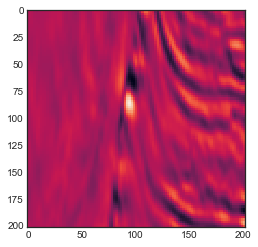

In [38]:
plt.imshow(img2)